## Out-of-source-domain Masking / add_matrix_NaNs / add_nans_to_weights

If specifying an input mask when the regridding weights are generated, or, if the destination domain is larger than the source domain, one has to mask out-of-source-domain cells by manipulating the regridding weights,
as suggested by Nic Wayand (function "add_matrix_NaNs"): https://github.com/JiaweiZhuang/xESMF/issues/15#issuecomment-371646763

Else the out-of-source-domain cells of the target grid will be given the value 0. 

In my opinion it is best to apply out-of-source-domain masking (or add_nans_to_weights/add_matrix_NaNs) by default for all but the nearest neighbour methods.
At the moment (xESMF 0.5.3) it is applied only if a mask exists for the target/output grid:

#### xesmf/frontend.py
```python
class Base_regridder(...)
[...]
    def __init__(...):
        [...]
        
        # replace zeros by NaN in mask
        if self.grid_out.mask is not None and self.grid_out.mask[0] is not None:
            self.weights = add_nans_to_weights(self.weights)
            
        [...]   
```

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import scipy
import warnings
warnings.simplefilter("ignore")
xr.set_options(display_style='html');

print("Using xESMF in version %s" % xe.__version__)

Using xESMF in version 0.5.3.dev11+gcb46501


### add_matrix_NaNs / add_nans_to_weights

In [2]:
def add_matrix_NaNs(regridder):
    """Add Nans to matrices, which makes any output cell with a weight from a NaN input cell = NaN"""
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    # indptr: https://stackoverflow.com/questions/52299420/scipy-csr-matrix-understand-indptr
    # Creates array with length nrows+1 with information about non-zero values,
    #  with np.diff calculating how many non-zero elements there are in each row
    num_nonzeros = np.diff(M.indptr) 
    # Setting rows with only zeros to NaN
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder


def double_plot(da0, da1, suptitle):
    fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True, sharey=True,
                                   subplot_kw={'aspect': 1}, figsize=(9, 4))
    xi,yi = np.meshgrid(da0.lon.values, da0.lat.values)
    xo,yo = np.meshgrid(da1.lon.values, da1.lat.values)
    da0.plot(ax=ax0, add_colorbar=True, vmin=0, vmax=1)
    ax0.set_title('Input')
    #ax0.grid()
    ax0.scatter(xo,yo, marker="x", c="r")    
    ax0.scatter(xi,yi)    
    da1.plot(ax=ax1, add_colorbar=True, vmin=0, vmax=1)
    ax1.set_title('Output')
    #ax1.scatter(xo,yo, marker="x", c="r")  
    #ax1.scatter(xi,yi)
    #ax1.grid()
    plt.axis([0, 4, -1, 5])
    plt.suptitle(suptitle, weight="bold")
    plt.show()

### Test dataset 

In [3]:
# Input dataset
tempi = np.linspace(0,1,16).reshape(4,4)
tempi[1, 1] = np.nan
dsi = xr.Dataset(
    {'temp': (['lat', 'lon'], tempi),
     'lon_b': ('nxb', [0., 1., 2., 3., 4.]),
     'lat_b': ('nyb', [0., 1., 2., 3., 4.])},
    coords={'lat': [.5, 1.5, 2.5, 3.5], 'lon': [.5, 1.5, 2.5, 3.5]})

# Input grid
gridi = xr.Dataset(
    {'lon_b': ('nxb', [0., 1., 2., 3., 4.]),
     'lat_b': ('nyb', [0., 1., 2., 3., 4.])},
    coords={'lat': [.5, 1.5, 2.5, 3.5], 'lon': [.5, 1.5, 2.5, 3.5]})

# Input grid (incl. mask)
gridi_masked = xr.Dataset(
    {'mask': (('lat', 'lon'), dsi['temp'].notnull()), 
     'lon_b': ('nxb', [0., 1., 2., 3., 4.]),
     'lat_b': ('nyb', [0., 1., 2., 3., 4.])},
    coords={'lat': [.5, 1.5, 2.5, 3.5], 'lon': [.5, 1.5, 2.5, 3.5]})

# Output grid
grido = xr.Dataset(
    {'lon_b': ('nxb', [.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75]),
     'lat_b': ('nyb', [-0.75, -0.25, .25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75])},
    coords={'lat': [-0.5, 0., .5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5], 'lon': [.5, 1., 1.5, 2., 2.5, 3., 3.5]})

### conservative

Cell centers of source grid (left-hand-side) are depicted in blue.
Cell centers of the destination grid (right-hand-side) are depicted in red.

Conservative: Preserves the integral of the source field across the regridding.
For this method, weight calculation is based on the ratio of source cell area
overlapped with the corresponding destination cell area.


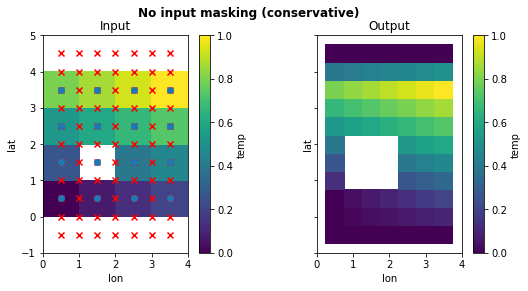

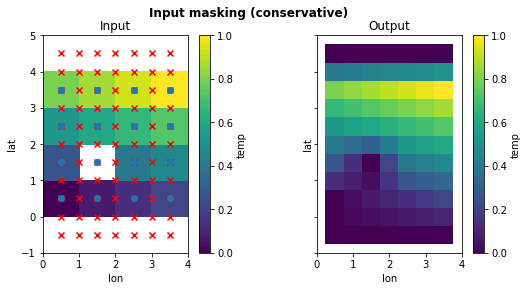

Additionally applying 'add_matrix_NaNs', masks the unwanted 0 values that ESMF returns in that case:


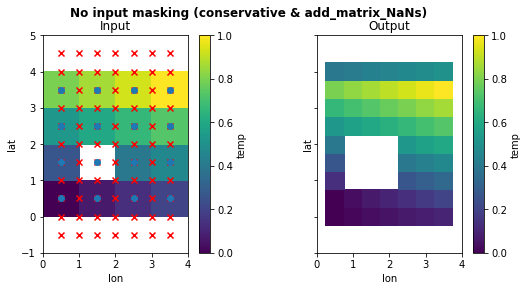

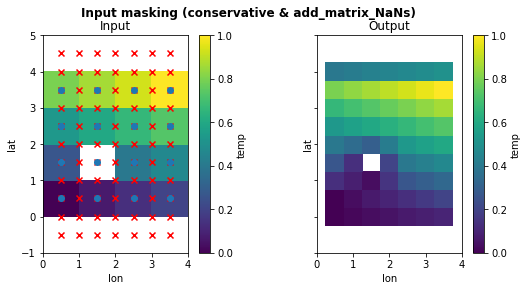

In [4]:
# Regridding
# ----------

# No Input mask - conservative
rg = xe.Regridder(gridi, grido, method="conservative")
tempo = rg(dsi['temp'])
print("Cell centers of source grid (left-hand-side) are depicted in blue.")
print("Cell centers of the destination grid (right-hand-side) are depicted in red.\n")
print("Conservative: Preserves the integral of the source field across the regridding.\n"
      "For this method, weight calculation is based on the ratio of source cell area\n"
      "overlapped with the corresponding destination cell area.")
double_plot(dsi['temp'], tempo, "No input masking (conservative)")

# Input masking - conservative
rg = xe.Regridder(gridi_masked, grido, method="conservative")
tempo = rg(dsi['temp'])
double_plot(dsi['temp'], tempo, "Input masking (conservative)")

# No input masking - conservative, add_matrix_NaNs
print("Additionally applying 'add_matrix_NaNs', masks the unwanted 0 values that ESMF returns in that case:")
rg = xe.Regridder(gridi, grido, method="conservative")
rg = add_matrix_NaNs(rg)
tempo = rg(dsi['temp'])
double_plot(dsi['temp'], tempo, "No input masking (conservative & add_matrix_NaNs)")

# Input masking - conservative, add_matrix_NaNs
rg = xe.Regridder(gridi_masked, grido, method="conservative")
rg = add_matrix_NaNs(rg)
tempo = rg(dsi['temp'])
double_plot(dsi['temp'], tempo, "Input masking (conservative & add_matrix_NaNs)")

### bilinear

Bilinear: Linear interpolation in 2 or 3 dimensions.


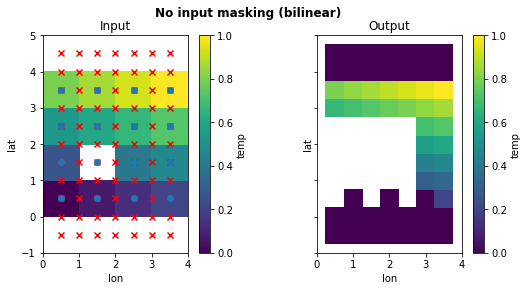

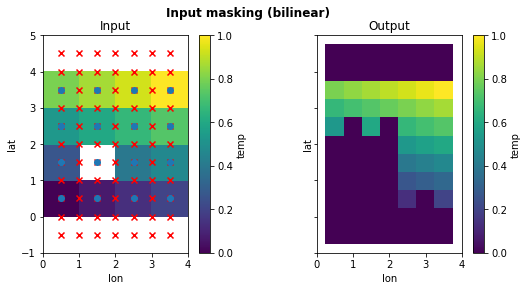

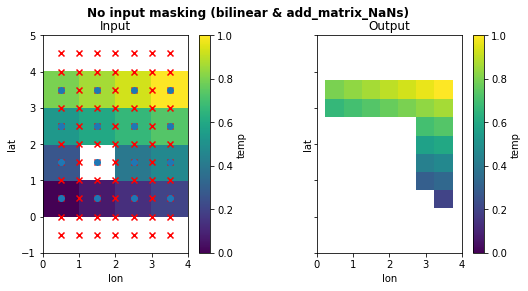

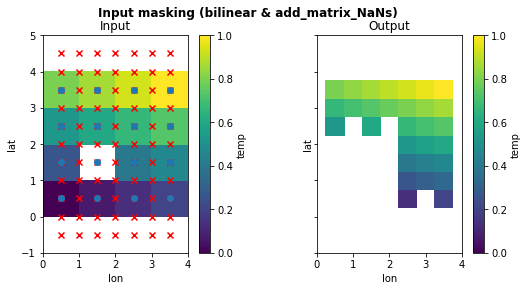

In [5]:
# Regridding
# ----------

# No Input mask - bilinear
rg = xe.Regridder(gridi, grido, method="bilinear")
tempo = rg(dsi['temp'])
print("Bilinear: Linear interpolation in 2 or 3 dimensions.")
double_plot(dsi['temp'], tempo, "No input masking (bilinear)")

# Input mask - bilinear
rg = xe.Regridder(gridi_masked, grido, method="bilinear")
tempo = rg(dsi['temp'])
double_plot(dsi['temp'], tempo, "Input masking (bilinear)")

# No Input mask - bilinear, add_matrix_NaNs
rg = xe.Regridder(gridi, grido, method="bilinear")
rg = add_matrix_NaNs(rg)
tempo = rg(dsi['temp'])
double_plot(dsi['temp'], tempo, "No input masking (bilinear & add_matrix_NaNs)")

# Input mask - bilinear, add_matrix_NaNs
rg = xe.Regridder(gridi_masked, grido, method="bilinear")
rg = add_matrix_NaNs(rg)
tempo = rg(dsi['temp'])
double_plot(dsi['temp'], tempo, "Input masking (bilinear & add_matrix_NaNs)")

### patch

Patch: Patch rendezvous method of taking the least squares fit of the surrounding
surface patches. This is a higher order method that may produce interpolation
weights that may be slightly less than 0 or slightly greater than 1.


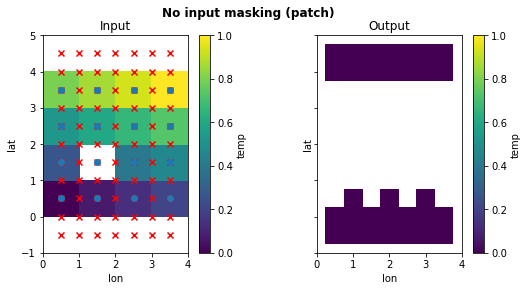

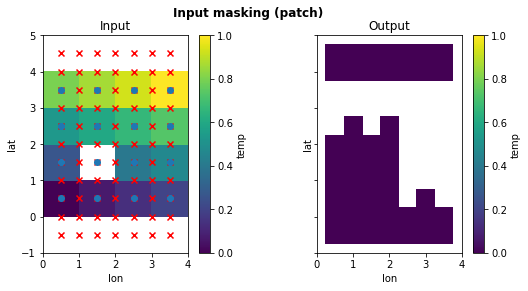

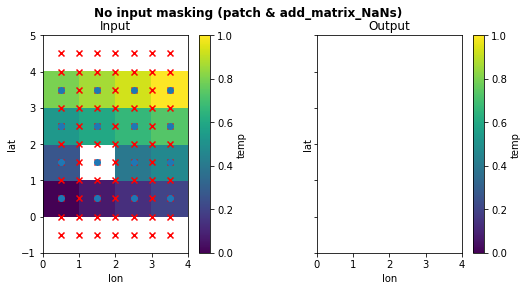

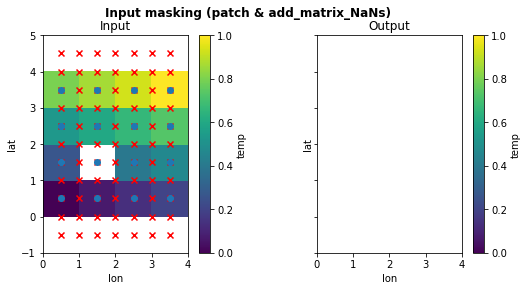

In [6]:
# Regridding
# ----------

# No Input mask - patch
rg = xe.Regridder(gridi, grido, method="patch")
tempo = rg(dsi['temp'])
print("Patch: Patch rendezvous method of taking the least squares fit of the surrounding\n"
      "surface patches. This is a higher order method that may produce interpolation\n" 
      "weights that may be slightly less than 0 or slightly greater than 1.")
double_plot(dsi['temp'], tempo, "No input masking (patch)")

# Input mask - patch
rg = xe.Regridder(gridi_masked, grido, method="patch")
tempo = rg(dsi['temp'])
double_plot(dsi['temp'], tempo, "Input masking (patch)")

# No input mask - patch, add_matrix_NaNs
rg = xe.Regridder(gridi, grido, method="patch")
rg = add_matrix_NaNs(rg)
tempo = rg(dsi['temp'])
double_plot(dsi['temp'], tempo, "No input masking (patch & add_matrix_NaNs)")

# Input mask - patch, add_matrix_NaNs
rg = xe.Regridder(gridi_masked, grido, method="patch")
rg = add_matrix_NaNs(rg)
tempo = rg(dsi['temp'])
double_plot(dsi['temp'], tempo, "Input masking (patch & add_matrix_NaNs)")

### nearest_s2d

nearest_s2d:  map each destination point to nearest source point
(not every source point might be mapped, others might have multiple
destination points as counterparts.


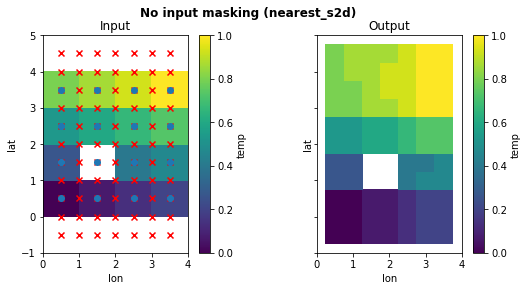

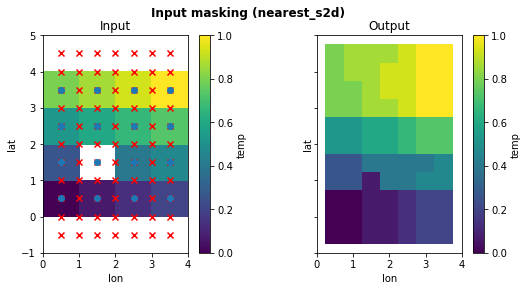

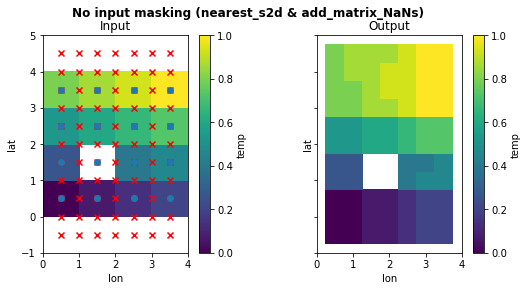

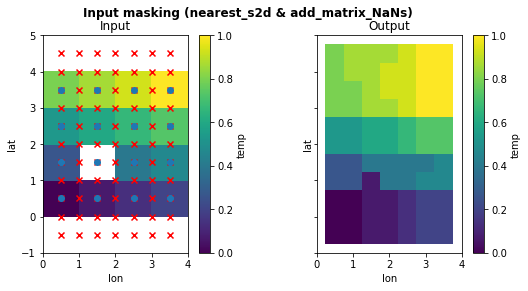

In [7]:
# Regridding
# ----------

# No Input mask - nearest_s2d
rg = xe.Regridder(gridi, grido, method="nearest_s2d")
tempo = rg(dsi['temp'])
print("nearest_s2d:  map each destination point to nearest source point\n"
      "(not every source point might be mapped, others might have multiple\n"
      "destination points as counterparts.")
double_plot(dsi['temp'], tempo, "No input masking (nearest_s2d)")

# Input mask - nearest_s2d
rg = xe.Regridder(gridi_masked, grido, method="nearest_s2d")
tempo = rg(dsi['temp'])
double_plot(dsi['temp'], tempo, "Input masking (nearest_s2d)")

# No input mask - nearest_s2d, add_matrix_NaNs
rg = xe.Regridder(gridi, grido, method="nearest_s2d")
rg = add_matrix_NaNs(rg)
tempo = rg(dsi['temp'])
double_plot(dsi['temp'], tempo, "No input masking (nearest_s2d & add_matrix_NaNs)")

# Input mask - nearest_s2d, add_matrix_NaNs
rg = xe.Regridder(gridi_masked, grido, method="nearest_s2d")
rg = add_matrix_NaNs(rg)
tempo = rg(dsi['temp'])
double_plot(dsi['temp'], tempo, "Input masking (nearest_s2d & add_matrix_NaNs)")